#Functions and code for plotting MEATseq m6A probability stats and read clustering

#This example jup notebook corresponds to the analysis of data presented in Figure 2 and Extended Data Fig 1 of Altemose et. al. 2022 Nature Methods paper.
#Used for analyzing 1x601 Chromatin DiMeLo-seq and sensitivity measurements
#Trial 12 - (CA G1, Naked) (CA targeted, IgG, Free floating, untreated) Top 5k reads only

In [ ]:
#Input Megaladon output - mod_mappings.bam (filter by length to keep file size small)
#Template - 1x601.fa
#Functions:
# parse_bam6_fast - takes in bam file, reads through each read entry and outputs prob score at each A and coverage at each position along the given template. Other outputs include smoothed/sliding window averaged prob score, binary output for m6A call at each A position, number of modified A's and number of A's per read for other statistics, readids.
# extract_Ml_Aa_fast - takes in Mm and Ml from Megaladon output for each read. converts to array with just m6A calls with the correct index (removes mC prob scores)
# m6A_seqmap_prob_fast - takes in positions of A's and T's along template and assigns prob scores from Ml of megaladon output

In [1]:
##Replace <outdir> with output directory
outfolder = '<outdir>'

In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kde
%matplotlib inline

import math

import pysam
from Bio import SeqIO

from scipy import sparse

from sklearn import cluster, datasets, mixture, decomposition

import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
#enter name of folder that contains bar1.1, bar1.2,.. etc. bam files mod_basecalled from megalodon
folder_name = '<folder_name>'

In [4]:
Barcode_name = {}

In [5]:
#List Barcode titles to be used for graphs here: (For example)
Barcode_name[1] = 'CA Chr, CA-DiMeLo'
Barcode_name[2] = 'CA Chr, IgG-DiMeLo'
Barcode_name[3] = 'CA Chr, free pA-Hia5'
Barcode_name[4] = 'CA Chr, Untreated'
Barcode_name[5] = 'Naked, CA-DiMeLo'
Barcode_name[6] = 'Naked, IgG-DiMeLo'
Barcode_name[7] = 'Naked, free pA-Hia5'
Barcode_name[8] = 'Naked, Untreated'

In [6]:
Barcode_list = list(range(1,9))

In [7]:
#reading in template into string - filepath/template.fa
array_seq = SeqIO.read("<filepath/template.fa>", "fasta")
array_str = str(array_seq.seq)

In [8]:
#identifying indices of A's and T's for assigning mod probs to right positions

A_pos = []
T_pos = []
for basepos in range(0,len(array_str)-1):
    if array_str[basepos]=='A':
        A_pos.append(basepos)
    elif array_str[basepos]=='T':
        T_pos.append(basepos)

In [9]:
# extracting m6A prob from Ml, counting A
# input Mm Ml from bam and thr
# output - Mm first value, truncated m6A prob, total A count

In [10]:
def extract_Ml_Aa_fast(Mm, Ml):
         
    first=Mm.split(';')[0]
    if 'C+m' in first:
        A_n=len(Mm.split(';')[1].split(','))-1
        Mm_Aa = Mm.split(';')[1].split(',')[1:]
        Mm_Aa_start = int(Mm_Aa[0])
        Ml_Aa = np.array(Ml[0-A_n:],dtype=int)

    elif 'A+a' in first:
        A_n=len(Mm.split(';')[0].split(','))-1        
        Mm_Aa = Mm.split(';')[0].split(',')[1:]
        Mm_Aa_start = int(Mm_Aa[0])
        Ml_Aa=np.array(Ml[0:A_n],dtype=int)
    
    return Mm_Aa_start, Ml_Aa, A_n

In [13]:
# m6A_seqmap_prob_fast - takes in A or T pos array and readmap start, returns mod prob values assigned to A's along the template
# input arguments - A pos array, T pos array, pos of read along template, if strand=rev, Mm_start, truncated Ml prob values, read length, template length) thresholding done later
# output - m6A prob score along template, coverage along template - for each read

In [14]:
def m6A_seqmap_prob_fast(A_pos_array, T_pos_array, Readmap_start, rev_strand, Mm_start, Ml_Aa, readlength, templatelength = 730):
    readfilter = False
    if rev_strand == False:
      
    #finding position of first A
        if (Readmap_start < A_pos_array[0]):
                first_A_index = A_pos_array[0]
                
        for i in range(0,len(A_pos_array)-1):
            if ((A_pos_array[i]) <= Readmap_start) and (Readmap_start < (A_pos_array[i+1])):
                if A_pos_array[i] == Readmap_start:
                    first_A_index = i + Mm_start
                else:
                    first_A_index = i+1+Mm_start
                
        #sequence pos of all A's in read
        AT_prob_read = np.empty(templatelength)
        AT_prob_read[:] = np.NaN
        for j in range(0,len(Ml_Aa)-1):
            if first_A_index + j <= len(A_pos_array)-1:
                A_index = A_pos_array[first_A_index+j]
                AT_prob_read[A_index] = Ml_Aa[j]
            else:
                readfilter = True
        
    elif rev_strand == True:

        if (Readmap_start < T_pos_array[0]):
                first_T_index = T_pos_array[0]

    #finding position of first T
        for i in range(0,len(T_pos_array)-1):
            if ((T_pos_array[i]) <= Readmap_start) and (Readmap_start < (T_pos_array[i+1])):
                if T_pos_array[i] == Readmap_start:
                    first_T_index = i + Mm_start
                else:
                    first_T_index = i+1+Mm_start
                
                #print(T_pos_array[i], Readmap_start, T_pos_array[first_T_index], T_pos_array[i+1], rev_strand)
                
        #sequence pos of all A's in read
        AT_prob_read = np.empty(templatelength)
        AT_prob_read[:] = np.NaN
        for j in range(0,(len(Ml_Aa)-1)):
            if first_T_index + j <= len(T_pos_array)-1:
                T_index = T_pos_array[first_T_index+j]
                AT_prob_read[T_index] = Ml_Aa[j]
            else:
                readfilter = True
                
    #sequence coverage
    Readmap_end = Readmap_start + readlength - 1
    AT_pos_read = np.zeros(templatelength,dtype=int)
    for k in range(Readmap_start, Readmap_end):
        AT_pos_read[k] = 1
    
    return AT_prob_read, AT_pos_read, readfilter

In [15]:
def parse_bam6_fast(filename, numreads = 5000, templatelength = 730):
    reader = pysam.AlignmentFile(filename, check_sq=False)
    bamiter= reader.fetch(until_eof=True)

    A_n=[]
    readids=[]
    rev_read_list=[]
    
    AT_prob_list = []
    coverage_Fwd = np.zeros(templatelength,dtype=int)
    coverage_Rev = np.zeros(templatelength,dtype=int)
    
    
    readfilter_list = []
    count = 0
    
    while True:
        try:
            r=bamiter.__next__()
            Mm=(r.get_tag('Mm') if r.has_tag('Mm') else None)
            Ml=(r.get_tag('Ml') if r.has_tag('Ml') else None)
            readid=r.query_name
            pos=r.reference_start
            #pos in bam is 1 indexed, python is 0 indexed
            pos=pos-1
            length=r.query_length
            rev_strand=r.is_reverse
            
            if count < numreads:
                if not Mm is None:
                    
                    Mm_Aa_start, Ml_Aa, read_A_n = extract_Ml_Aa_fast(Mm, Ml)
                    if rev_strand ==True:
                        Mm_Aa_start = 0
                        Ml_Aa = Ml_Aa[::-1]
                    AT_prob_read, AT_pos_read, readfilter = m6A_seqmap_prob_fast(A_pos, T_pos, pos, rev_strand, Mm_Aa_start, Ml_Aa, length)
                    if readfilter == False:                    
                        AT_prob_list.append(AT_prob_read)
                        A_n+=[read_A_n]
                        readids+=[readid]
                        rev_read_list+=[rev_strand]

                        if rev_strand == False:
                            coverage_Fwd += AT_pos_read
                        elif rev_strand == True:
                            coverage_Rev += AT_pos_read

                        count += 1
                    else:
                        print(readid)

        except StopIteration:
            reader.close()

            
            AT_prob_arr = np.array(AT_prob_list)
            
            
            return AT_prob_arr, coverage_Fwd, coverage_Rev, A_n, readids, rev_read_list

BarCode All through for loop

In [16]:
import time

In [17]:
def by_barcode(folder_path, barcodes_list = Barcode_list, numreads = 5000):
    AT_prob_arr_bar = {new_list: [] for new_list in barcodes_list} 
    coverage_Fwd_bar = {new_list: [] for new_list in barcodes_list} 
    coverage_Rev_bar = {new_list: [] for new_list in barcodes_list} 
    A_n_bar = {new_list: [] for new_list in barcodes_list} 
    readids_bar = {new_list: [] for new_list in barcodes_list} 
    rev_read_list_bar = {new_list: [] for new_list in barcodes_list} 
    filename = {}
    for i in barcodes_list:
        start_time = time.time()
        #Iterate through file names here: (for example)
        filename[i] = folder_path + 'bar' + str(i) + '.1/mod_mappings_700bp.bam'
        AT_prob_arr_bar[i], coverage_Fwd_bar[i], coverage_Rev_bar[i], A_n_bar[i], readids_bar[i], rev_read_list_bar[i] = parse_bam6_fast(filename[i], numreads)
        
        print('Finished barcode ', i, 'in ', "--- %s seconds ---" % (time.time() - start_time))
        
    return AT_prob_arr_bar, coverage_Fwd_bar, coverage_Rev_bar, A_n_bar, readids_bar, rev_read_list_bar

In [18]:
AT_prob_arr_bar, coverage_Fwd_bar, coverage_Rev_bar, A_n_bar, readids_bar, rev_read_list_bar = by_barcode(folder_name, Barcode_list, 5000)

d7690d39-ae38-4995-96be-85d7f3107cd1
cb3c1fda-7e08-4bac-a813-9fecf03d705a
03066b54-95e3-4865-8b43-e7e9ee71c81f
12a37f85-a877-4bed-bf19-16f940cf04a7
9907d2fc-0787-4dc5-aa46-0764ecc0de8a
7ac44291-69e6-490c-9aaf-a2be2a5e8e3f
ee54de33-4fb8-4598-bc0c-416d4ef7413b
c1497ebe-2b12-45d9-ae41-b707d1c53366
fed43dc7-62ca-4f66-8c76-54c3dd8e5219
64214f08-8cd1-4469-9127-fdc5783034c5
832df804-6e8b-4916-a3b5-59a06adc1420
06eba39b-b3a8-4127-998b-103333ca7c16
83f004b7-877e-4357-96b2-335de85221af
0a0ebcb5-91e5-4c19-b7c3-b7bc77d1a7b1
aa69a298-1277-4bc6-b986-f29e3c638031
fd2434b4-9660-4f66-a740-ad0bff16e8da
49ffd17c-e6c2-48b9-9c3a-90a525bbf030
76f3ba80-ee4f-4dad-8bbc-72a30e8ddbf7
d35129bc-8a29-49d2-86fb-7aa3aa07e571
fb8e3677-f5f3-4cdb-9264-f1747ef44352
33a1474f-af78-48fb-9ed3-1b5cd5b8b13f
04d78125-1279-4085-827c-98bcdac9947a
35cf5734-f662-4687-83a1-0d5ad0972f20
9989631f-2d08-4697-88d4-a89da1dd5600
460723bc-e6f2-4b65-98d4-aef7c98a601e
6684e97e-b989-483c-8f88-ac5ea423c626
9becbf35-4fc5-43d7-a3ad-04f1e195da56
3

17583c94-7e3f-4a6f-a8e7-f3653de4a10c
f0d319aa-75b4-42c9-988b-6537c69aa420
4dc68cbb-8c00-40bd-aa0b-a5481d19c72b
b616470d-e6ae-4975-921e-1cc73d1e2658
d8cbe233-f5e8-4bb4-87fe-14829af932e6
832bb2af-0ee7-42e6-815e-f099bca0567f
c2db7845-1ccc-445f-9510-6767304b27cf
Finished barcode  3 in  --- 3.4258992671966553 seconds ---
41515e01-bfd8-41da-b32e-6d9ddb8f9b26
2ccbbd50-37f9-4be6-b2e5-9594718b1cd6
e4dc912c-bb30-4d2c-9ced-5cc23c5cbf75
25d3e910-b2ef-479c-b1ec-23e36664bd0a
7ee5a740-1049-4b6b-8301-62853294ddb6
8c424165-1f20-4262-a2df-ca7f5a2a3b57
62af7d6b-b068-4b7c-a53f-1cc313d66eea
dcd6e796-2b19-4c5a-b875-66023919f528
3a8fd9f4-756e-4a69-99bd-5eeba7c44462
194acbee-7c50-4f8a-9928-92c88be6ac38
7474448f-7be7-4d2d-91dc-a4631674dc8b
fb981343-3c4c-47cf-ad4c-9397c0a58063
9d724cd8-f404-49bb-a48a-1f351e155e87
fd0ac398-d295-4876-a93e-d01b9a1fba4e
04c83372-6092-4335-a4c3-7df623f48e7e
de740fb2-1b43-4718-8be5-b004022b1569
b101949e-8edf-4444-8740-6661891889a2
e0d67eac-5d45-4cf7-9fcd-69d33a9ab4dc
95fae6e3-0661-43

f1491271-4006-4f08-89dc-c2ab7f76f724
a6fcf9c8-d513-4dc2-a41d-2274cc6fb13b
6ffa28c3-b88e-496a-9ab3-5b586117b974
34cf39dc-669f-4be4-ad8d-cf06629db14c
7a534653-75e8-473a-bd8c-d2166084f75e
cf116fc3-bc81-4169-88ff-8467ea814f38
77973b98-a463-4d26-b416-0d866a57f870
7ea2c501-0d8e-41b0-8a42-1117669dc6b5
84037324-d8a5-4eb2-91e9-17173ce3dc97
2c0b93f1-b0ef-4813-ba2c-1554bfd3a41e
53d6146b-a1a7-4962-8b17-3ea2346e215a
672633c3-fedd-4bbb-a4cd-d11d28ce9c0e
e1f0e5c1-d540-4f2e-8650-c023bf10b1d6
45918938-53a3-483d-ad22-c256fcb4b81a
Finished barcode  5 in  --- 8.525460004806519 seconds ---
41f1dc66-96aa-436b-afcc-a7ae468f91c5
633c7a39-4b75-42b8-8439-f76b6369526e
f33f193c-7872-424c-ba7a-fa3e541c6ec7
51f2fa91-b9a8-4f3e-95f8-f78b160e5df9
a63ba22b-ec4c-48c0-8b75-71988f35735f
c2b1f662-cb88-4aa0-abf3-eb3be6db1e4d
cfbf6832-23ce-4720-af4c-56c0fc2d6099
208207f1-5215-4619-a74f-eb87a6dfc51e
3f203400-90ac-4c07-a4d8-0bac8a1f5a15
a780e080-646c-498f-bda5-688743e021db
b2520f31-67d1-4078-98fc-1e252d085d79
680f81c5-e817-452

ee528db3-7398-4a50-b794-87601e394e14
b166c7be-3872-4416-923f-780ca5169005
d8b42cbc-ed0d-4562-85c9-9d03eb2c9bd8
4280058a-e31c-46a0-b9c1-bca070671ec8
a0739423-3b81-4e79-85a5-2dce0a07cd94
0ea3b4bf-e785-4e57-ac18-ecb54f165ada
ab90cb76-4bad-442e-a839-d88f693c575e
eed62546-8e68-4c3c-96da-ab5d1d4122b5
e05b3ecb-2f85-47c0-b6b0-578dc42f62d7
154c03f5-aa40-4e1e-8ded-c01cabf3c55d
8ead292e-5d7c-4c49-a201-bc41bd9dd93d
aedd8aa2-6c7a-423e-941b-f1157b2656a5
ebff9f24-a110-4cbd-a69e-258422d3a74d
8ff59b8f-f062-4dc3-8c2f-597ffb3f114a
63535d8f-0385-4667-b518-9385920001c6
4ddb87b6-9b58-4df2-b49f-442ec014225c
c385171d-e63c-4b6c-a40c-cd1f1765d28e
c5af1da7-dd78-4ccf-b900-5dbfbf2bb595
db8cc4bf-c39b-46b6-8c5b-04b0ce1eaf22
83fa5576-ae07-48f8-b78e-342c74237272
61c85770-2dd8-4f81-9b3c-68b23c51dcb2
8c9bcb40-4325-4829-b642-6aeef4e63deb
a8fe5b69-a634-4da7-a099-20aebeae5f9c
5e2db6d4-f2c4-4255-a224-c8c8a52e312c
612ac2c0-d910-40f7-a85b-c914b1b6a4ea
c1b46608-de71-4343-b64e-319a1ed956ca
65e1f731-de80-4708-a2e6-6fe38f6b5d31
6

In [19]:
#COVERAGE
def coverage(barcodes_list, coverage_Fwd_bar, coverage_Rev_bar, templatelength = 730, label_name = Barcode_name):
    coverage_bar = {new_list: [] for new_list in barcodes_list}
    x = np.arange(templatelength)    
    for i in barcodes_list:
        coverage_bar[i] = coverage_Fwd_bar[i] + coverage_Rev_bar[i]
        plt.plot(x, np.array(coverage_bar[i]), label = label_name[i])
    plt.xlabel('bp of 1x601 730 bp', fontsize = 14)
    plt.ylabel('# of read', fontsize = 14)
    plt.title('coverage', fontsize=14)
    legend = plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    return coverage_bar

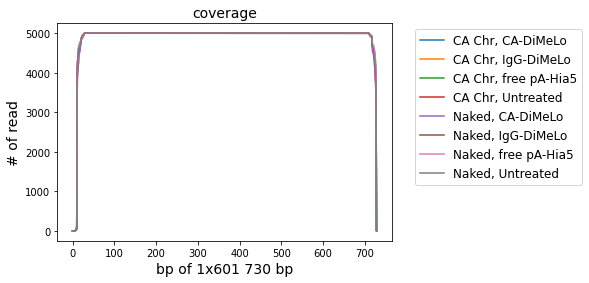

In [20]:
coverage_bar = coverage(Barcode_list, coverage_Fwd_bar, coverage_Rev_bar)

In [27]:
#Calculating FDR from CDF

In [33]:
barcodes_list = [1,2,3,4,5,6,7,8]

In [24]:
histo = {new_list: [] for new_list in barcodes_list}
bin_edges = {new_list: [] for new_list in barcodes_list}
AT_prob_list_clean_bar = {new_list: [] for new_list in barcodes_list}
cdf = {new_list: [] for new_list in barcodes_list}
for i in barcodes_list:
    AT_prob_list_clean_bar[i] = np.reshape(AT_prob_arr_bar[i][AT_prob_arr_bar[i]>=0],-1)
    histo[i], bin_edges[i] = np.histogram(AT_prob_list_clean_bar[i]/255, density = True, bins=1000)
    cdf[i] = np.cumsum(histo[i])/np.nansum(histo[i])
    

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


In [ ]:
#FDR calculation without binning

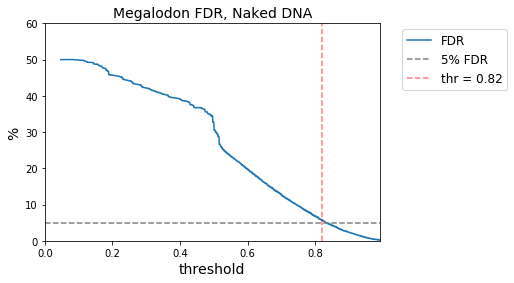

In [30]:
plt.plot(bin_edges[7][:-1],np.divide((1-cdf[8]),((1-cdf[7])+(1-cdf[8])))*100, label = 'FDR' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.82, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.82')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Megalodon FDR, Naked DNA', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [30]:
#making a binary mod prob > thr array using numpy
def binary_mod(barcodes_list, AT_prob_arr_bar, coverage_bar, AT_mod_arr_bar={}, thr=88):
    thr256 = thr/100*256
    try: AT_mod_arr_bar
    except NameError: 
        AT_mod_arr_bar = {new_list: [] for new_list in barcodes_list}
    for i in barcodes_list:
        AT_mod_arr_bar[i] = np.ndarray.astype(AT_prob_arr_bar[i] >= thr256, int)
    return AT_mod_arr_bar

In [31]:
AT_mod_arr_bar = binary_mod(Barcode_list, AT_prob_arr_bar, coverage_bar)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  


In [32]:
#making a binary mod prob > thr array using numpy
def frac_m6A(barcodes_list, AT_mod_arr_bar, A_n_bar, m6A_over_A_bar = {}):
    N_mod_bar = {new_list: [] for new_list in barcodes_list}
    for i in barcodes_list:
        N_mod_bar[i] = AT_mod_arr_bar[i].sum(axis = 1)
        m6A_over_A_bar[i] = np.ndarray.astype(N_mod_bar[i]/A_n_bar[i], float)
    return m6A_over_A_bar

In [33]:
m6A_over_A_bar = frac_m6A(Barcode_list, AT_mod_arr_bar, A_n_bar)

In [34]:
colorpal = ['#BB4420','#FFBC0A','#053C5E','#A9E5BB','#610345','#2D1E2F','#559CAD','#5E747F', '#FF0000', '#00FF00', '#FFFF00']

In [38]:
def plot_m6A_over_A_combined(barcodes_list, m6A_over_A_bar, ylimit=(0,22), xlimit = (0,1), num_bins = 100, label_name = Barcode_name, colorpal = ['#FFBC0A','#053C5E','#559CAD','#610345','#A9E5BB','#2D1E2F','#BB4420','#5E747F']):

    def export_legend(legend, filename="legend.png"):
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(filename, dpi=300, bbox_inches=bbox)
        return
    fig, ax1 = plt.subplots(figsize = (3.6,2.4))
    barcodes_list_str = ''
    a = 0
    alp = [0.6,0.6,0.4,0.4]
    for i in barcodes_list:
        barcodes_list_str += '_' + str(i)
        ax1.hist(m6A_over_A_bar[i], bins = 75, density = True, alpha = alp[a], label = label_name[i], color = colorpal[a], histtype = 'barstacked')
        ax1.set_ylabel('frequency', fontsize = 14)
        ax1.set_ylim(0,20)
        ax1.set_xlabel('mA/A per read', fontsize = 14)
        ax = ax1.twinx()
        ax.hist(m6A_over_A_bar[i], bins = 1000, density = True, alpha = 1, label = label_name[i], cumulative=True, histtype='step', rwidth = 1, color = colorpal[a])
        ax.set_ylabel('fraction of reads', fontsize = 14)
        ax.set_ylim(0,1)
        a += 1
        legend = plt.legend(fontsize=12, bbox_to_anchor=(1.2, 1-a/6), loc='upper left')
        
    
    #plt.xlabel('mA/A (per read)', fontsize = 14)
    #plt.legend(fontsize=14)
    #legend = plt.legend(fontsize=12, bbox_to_anchor=(1.2, 1), loc='upper left')
    #plt.ylim(ylimit)
    plt.xlim(xlimit)
    plt.show()
    #if cumul == True:
    fig.savefig(outfolder+'plot_m6A_over_A_Cumulative_hist_combined_88_'+barcodes_list_str, dpi = 300, bbox_inches='tight')
    export_legend(legend, str(outfolder + 'plot_m6A_overA_Cumulative_hist_combined_legend_88_'+ barcodes_list_str + '.png'))
    #else:
    #    fig.savefig(outfolder+'plot_m6A_over_A_'+barcodes_list_str, dpi = 300, bbox_inches='tight')
    #    export_legend(legend, str(outfolder + 'plot_m6A_overA_legend_'+ barcodes_list_str + '.png'))
    

    
    return

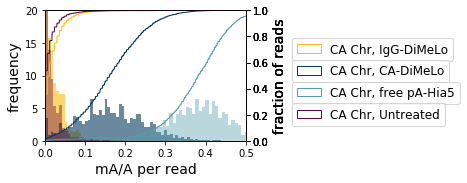

In [39]:
ax = plot_m6A_over_A_combined([2,1,3,4],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,0.5], num_bins=1000)

### Binning and Sensitivity measurement

In [21]:
AT_prob_arr_bar_filt50 = {}
for i in Barcode_list:
    AT_prob_arr_bar_filt50[i] = AT_prob_arr_bar[i]
    AT_prob_arr_bar_filt50[i][AT_prob_arr_bar[i]<=130] = 0

In [22]:
for bp in ['A','T','AT']:
    AT_prob_arr_bar_filt50[bp] = np.zeros((5000,730))
    AT_prob_arr_bar_filt50[bp][:] = np.NaN
for baseind in A_pos:
    AT_prob_arr_bar_filt50['A'][:,baseind] = 130
for baseind in T_pos:
    AT_prob_arr_bar_filt50['T'][:,baseind] = 130
for baseind in A_pos:
    AT_prob_arr_bar_filt50['AT'][:,baseind] = 130
for baseind in T_pos:
    AT_prob_arr_bar_filt50['AT'][:,baseind] = 130


#### Set bin and step sizes here:

In [23]:
## Bin each read of 730 bp into 20 bp bins overlapping bins, 10 bp stepsize, Binning to identify at least 1 mA probability
binsize = 50
stepsize = 1
templatelength = 800

In [24]:
Barcode_name['A'] = 'A density'
Barcode_name['T'] = 'T density'
Barcode_name['AT'] = 'AT density'


In [25]:
colorpal = ['#BB4420','#053C5E','#610345','#2D1E2F','#A9E5BB','#FFBC0A','#559CAD', '#5E747F', '#FF0000','#00FF00', '#FFFF00']

### Average probability for each bin on read, and then average and normalize to Fiberseq and untreated

In [26]:
## Bin each read of 730 bp into 20 bp bins overlapping bins, 10 bp stepsize , Binning by averaging probability
AT_prob_arr_bin_mA = {}
for i in [1,2,3,4,5,6,7,8, 'A', 'T', 'AT']:
    AT_prob_arr_bin_mA[i] = np.zeros((5000,int(templatelength/stepsize)))
    indx = 0
    for a in range(stepsize,templatelength, stepsize):
        AT_prob_arr_bin_mA[i][:,indx] = np.nan_to_num(np.nanmean(AT_prob_arr_bar_filt50[i][:,a-int(binsize/2):a+int(binsize/2)], axis=1))/256
        indx += 1

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [56]:
##ROC Calculations:

## plotting TPR (% CENP-A DiMeLo > threshold) vs FPR (% Untreated > threshold
# Parameters to vary - Threshold, % of each read
thresh_list = []
TPR = {}
FPR = {}
TPR_fib = {}
TPR_nkd = {}
FPR_nkd = {}
FPR_IgG = {}
thresh_mod_list = []    
for thresh_numbins_frac in np.round(np.arange(0,0.25,0.05),2):
    thresh_list.append(thresh_numbins_frac)
    TPR[thresh_numbins_frac] = []
    FPR[thresh_numbins_frac] = []
    TPR_fib[thresh_numbins_frac] = []
    TPR_nkd[thresh_numbins_frac] = []
    FPR_nkd[thresh_numbins_frac] = []
    FPR_IgG[thresh_numbins_frac] = []
    
    for thresh_mod in np.round(np.arange(0,1.05,0.05),2):
        thresh_mod_list.append(thresh_mod)
        TPR[thresh_numbins_frac].append(np.mean(np.mean(AT_prob_arr_bin_mA[1]>thresh_mod, axis = 1) > thresh_numbins_frac))
        FPR[thresh_numbins_frac].append(np.mean(np.mean(AT_prob_arr_bin_mA[4]>thresh_mod, axis = 1) > thresh_numbins_frac))
        TPR_fib[thresh_numbins_frac].append(np.mean(np.mean(AT_prob_arr_bin_mA[3]>thresh_mod, axis = 1) > thresh_numbins_frac))
        TPR_nkd[thresh_numbins_frac].append(np.mean(np.mean(AT_prob_arr_bin_mA[7]>thresh_mod, axis = 1) > thresh_numbins_frac))
        FPR_IgG[thresh_numbins_frac].append(np.mean(np.mean(AT_prob_arr_bin_mA[2]>thresh_mod, axis = 1) > thresh_numbins_frac))
        
        FPR_nkd[thresh_numbins_frac].append(np.mean(np.mean(AT_prob_arr_bin_mA[8]>thresh_mod, axis = 1) > thresh_numbins_frac))
            


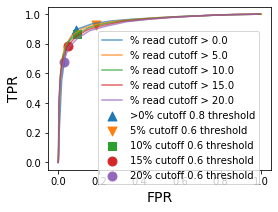

In [84]:
plt.figure(figsize = (4,3))
for thresh_numbins_frac in thresh_list:
    plt.plot(FPR[thresh_numbins_frac],TPR[thresh_numbins_frac], label = '% read cutoff > ' + str(np.round(thresh_numbins_frac*100)), alpha = 0.7)
    plt.ylabel('TPR', fontsize = 14)
    plt.xlabel('FPR', fontsize = 14)
plt.scatter(FPR[0][thresh_mod_list.index(0.8)], TPR[0][thresh_mod_list.index(0.8)], label = '>0% cutoff 0.8 threshold', marker = '^', s=80)
plt.scatter(FPR[0.05][thresh_mod_list.index(0.6)], TPR[0.05][thresh_mod_list.index(0.6)], label = '5% cutoff 0.6 threshold', marker = 'v', s=80)
plt.scatter(FPR[0.1][thresh_mod_list.index(0.6)], TPR[0.1][thresh_mod_list.index(0.6)], label = '10% cutoff 0.6 threshold', marker = 's', s = 80)
plt.scatter(FPR[0.15][thresh_mod_list.index(0.6)], TPR[0.15][thresh_mod_list.index(0.6)], label = '15% cutoff 0.6 threshold', marker = 'o', s=80)
plt.scatter(FPR[0.20][thresh_mod_list.index(0.6)], TPR[0.20][thresh_mod_list.index(0.6)], label = '20% cutoff 0.6 threshold', marker = 'o', s=80)
plt.savefig(outfolder + 'ROC_CA_Di_v_CA_Un.png', dpi = 300, bbox_to_anchor = 'tight')
plt.legend(bbox_to_anchor = (0.2,0.88))
plt.savefig(outfolder + 'ROC_CA_Di_v_CA_Un_withlegend.png', dpi = 300, bbox_to_anchor = 'tight')
plt.show()

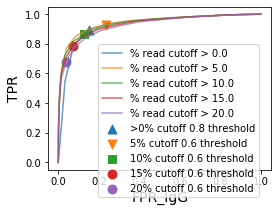

In [83]:
plt.figure(figsize = (4,3))
for thresh_numbins_frac in thresh_list:
    plt.plot(FPR_IgG[thresh_numbins_frac],TPR[thresh_numbins_frac], label = '% read cutoff > ' + str(np.round(thresh_numbins_frac*100)), alpha = 0.7)
    plt.ylabel('TPR', fontsize = 14)
    plt.xlabel('FPR_IgG', fontsize = 14)
plt.scatter(FPR_IgG[0][thresh_mod_list.index(0.8)], TPR[0][thresh_mod_list.index(0.8)], label = '>0% cutoff 0.8 threshold', marker = '^', s=80)
plt.scatter(FPR_IgG[0.05][thresh_mod_list.index(0.6)], TPR[0.05][thresh_mod_list.index(0.6)], label = '5% cutoff 0.6 threshold', marker = 'v', s=80)
plt.scatter(FPR_IgG[0.1][thresh_mod_list.index(0.6)], TPR[0.1][thresh_mod_list.index(0.6)], label = '10% cutoff 0.6 threshold', marker = 's', s = 80)
plt.scatter(FPR_IgG[0.15][thresh_mod_list.index(0.6)], TPR[0.15][thresh_mod_list.index(0.6)], label = '15% cutoff 0.6 threshold', marker = 'o', s=80)
plt.scatter(FPR_IgG[0.20][thresh_mod_list.index(0.6)], TPR[0.20][thresh_mod_list.index(0.6)], label = '20% cutoff 0.6 threshold', marker = 'o', s=80)

plt.savefig(outfolder + 'ROC_CA_Di_v_CA_IgG.png', dpi = 300, bbox_to_anchor = 'tight')
plt.legend(bbox_to_anchor = (0.2,0.8))
plt.savefig(outfolder + 'ROC_CA_Di_v_CA_Un_withlegend.png', dpi = 300, bbox_to_anchor = 'tight')
plt.show()

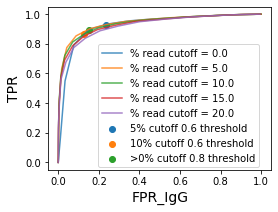

In [324]:
plt.figure(figsize = (4,3))
for thresh_numbins_frac in thresh_list:
    plt.plot(FPR_IgG[thresh_numbins_frac],TPR[thresh_numbins_frac], label = '% read cutoff = ' + str(np.round(thresh_numbins_frac*100)), alpha = 0.8)
    plt.ylabel('TPR', fontsize = 14)
    plt.xlabel('FPR_IgG', fontsize = 14)
plt.scatter(FPR_IgG[0.05][thresh_mod_list.index(0.6)], TPR[0.05][thresh_mod_list.index(0.6)], label = '5% cutoff 0.6 threshold', marker = 'o')
plt.scatter(FPR_IgG[0.1][thresh_mod_list.index(0.6)], TPR[0.1][thresh_mod_list.index(0.6)], label = '10% cutoff 0.6 threshold', marker = 'o')
#plt.scatter(FPR_IgG[0.15][thresh_mod_list.index(0.6)], TPR[0.15][thresh_mod_list.index(0.6)], label = '15% cutoff 0.6 threshold', marker = 'o')
plt.scatter(FPR_IgG[0][thresh_mod_list.index(0.8)], TPR[0][thresh_mod_list.index(0.8)], label = '>0% cutoff 0.8 threshold', marker = 'o')
plt.savefig(outfolder + 'ROC_CA_Di_v_CA_IgG.png', dpi = 300, bbox_to_anchor = 'tight')
plt.legend(bbox_to_anchor = (0.2,0.8))
plt.savefig(outfolder + 'ROC_CA_Di_v_CA_Un_withlegend.png', dpi = 300, bbox_to_anchor = 'tight')
plt.show()

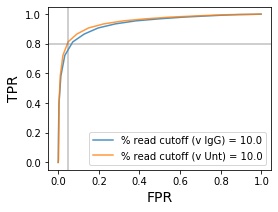

In [308]:
plt.figure(figsize = (4,3))
for thresh_numbins_frac in [0.1]:
    plt.plot(FPR_IgG[thresh_numbins_frac],TPR[thresh_numbins_frac], label = '% read cutoff (v IgG) = ' + str(np.round(thresh_numbins_frac*100)), alpha = 0.8)
    plt.ylabel('TPR', fontsize = 14)
    plt.xlabel('FPR', fontsize = 14)
    
    plt.plot(FPR[thresh_numbins_frac],TPR[thresh_numbins_frac], label = '% read cutoff (v Unt) = ' + str(np.round(thresh_numbins_frac*100)), alpha = 0.8)
    plt.legend()
    plt.axvline(0.05,0,1, color = 'grey', alpha = 0.5)
    plt.axhline(0.8,0,1, color = 'grey', alpha = 0.5)
plt.show()

In [309]:
import sklearn.metrics

In [320]:
auc = {}
for thresh_numbins_frac in thresh_list:
    auc[thresh_numbins_frac] = sklearn.metrics.auc(FPR[thresh_numbins_frac], TPR[thresh_numbins_frac])
    print(str(thresh_numbins_frac*100), '\t', np.round(auc[thresh_numbins_frac],2))

0.0 	 0.95
5.0 	 0.95
10.0 	 0.94
15.0 	 0.94
20.0 	 0.92


In [322]:
auc = {}
for thresh_numbins_frac in thresh_list:
    auc[thresh_numbins_frac] = sklearn.metrics.auc(FPR_IgG[thresh_numbins_frac], TPR[thresh_numbins_frac])
    print(str(thresh_numbins_frac*100), '\t', np.round(auc[thresh_numbins_frac],2))

0.0 	 0.92
5.0 	 0.94
10.0 	 0.93
15.0 	 0.93
20.0 	 0.92


#### Calculating FDR from CDF for binned probability:

In [134]:
#Calculating FDR from CDF

In [135]:
## Without masking on the center and edges

In [95]:
barcodes_list = [1,2,3,4,5,6,7,8]
histo_binned = {new_list: [] for new_list in barcodes_list}
bin_edges_binned = {new_list: [] for new_list in barcodes_list}
AT_prob_list_clean_bar_binned = {new_list: [] for new_list in barcodes_list}
cdf_binned = {new_list: [] for new_list in barcodes_list}
for i in barcodes_list:
    AT_prob_list_clean_bar_binned[i] = np.reshape(AT_prob_arr_bin_mA[i],-1)
    histo_binned[i], bin_edges_binned[i] = np.histogram(AT_prob_list_clean_bar_binned[i], density = True, bins=1000)
    cdf_binned[i] = np.cumsum(histo_binned[i])/np.nansum(histo_binned[i])
    

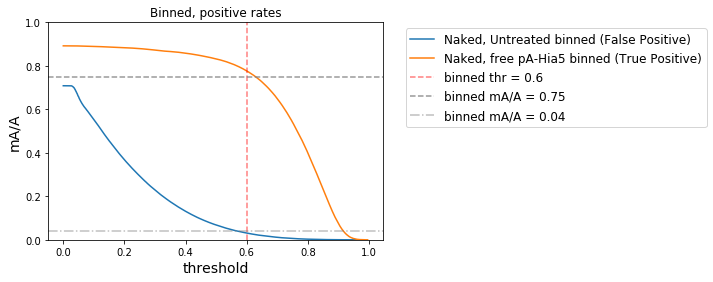

In [96]:
plt.plot(bin_edges_binned[8][:-1],1-cdf_binned[8], label = Barcode_name[8] + ' binned (False Positive)')
plt.plot(bin_edges_binned[7][:-1],1-cdf_binned[7], label = Barcode_name[7] + ' binned (True Positive)')
plt.ylabel('mA/A', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axvline(0.6, color='red', alpha=0.5, linestyle='--', label = 'binned thr = 0.6')
plt.axhline(0.75, color='grey', alpha=0.8, linestyle='--', label = 'binned mA/A = 0.75')
plt.axhline(0.04, color='grey', alpha=0.5, linestyle='-.', label = 'binned mA/A = 0.04')
plt.title('Binned, positive rates')
plt.ylim(0,1)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [106]:
def export_legend(legend, filename="legend.png"):
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(filename, dpi=300, bbox_inches=bbox)
        return


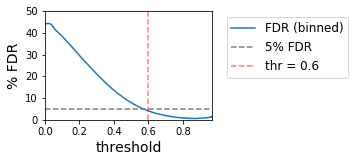

In [55]:
fig = plt.figure(figsize = (3,2))
plt.plot(bin_edges_binned[7][:-1],np.divide((1-cdf_binned[8]),((1-cdf_binned[7])+(1-cdf_binned[8])))*100, label = 'FDR (binned)' )
plt.ylabel('% FDR', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.6, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.6')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.title('Binned FDR, Naked DNA', fontsize = 14)
plt.ylim(0,50)
plt.xlim(0,0.97)
#plt.xlabel('threshold', fontsize=14)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig(outfolder+'FDR_50bp_Naked.png', dpi = 300, bbox_inches='tight')
export_legend(legend, str(outfolder + 'FDR50bp_Naked_legend.png'))
    
plt.show()


#### Calcualting FDR from binned probability scores after masking the center and edges

In [143]:
## Masking on the center and edges:
#In the following example and in the final figures, no masking was done over the center - hence mask_left = mask_right = 356

In [85]:
lefttrim = 160
righttrim = 610
mask_left = 356
mask_right = 356

In [86]:
AT_prob_arr_bin_mA_masktrim = {}
for i in [1,2,3,4,5,6,7,8]:
    AT_prob_arr_bin_mA_masktrim[i] = np.delete(AT_prob_arr_bin_mA[i][:,int(lefttrim/stepsize):int(righttrim/stepsize)],[int(b/stepsize) for b in range(mask_left - lefttrim,mask_right-lefttrim)], axis = 1)

In [149]:
histo_binned_masktrim = {new_list: [] for new_list in barcodes_list}
bin_edges_binned_masktrim = {new_list: [] for new_list in barcodes_list}
AT_prob_list_clean_bar_binned_masktrim = {new_list: [] for new_list in barcodes_list}
cdf_binned_masktrim = {new_list: [] for new_list in barcodes_list}
for i in barcodes_list:
    AT_prob_list_clean_bar_binned_masktrim[i] = np.reshape(AT_prob_arr_bin_mA_masktrim[i],-1)
    histo_binned_masktrim[i], bin_edges_binned_masktrim[i] = np.histogram(AT_prob_list_clean_bar_binned_masktrim[i], density = True, bins=1000)
    cdf_binned_masktrim[i] = np.cumsum(histo_binned_masktrim[i])/np.nansum(histo_binned_masktrim[i])
    

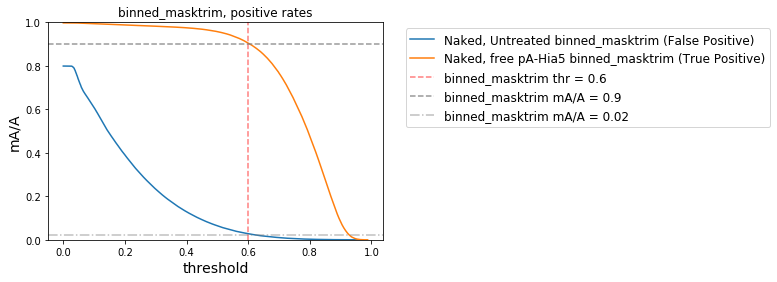

In [150]:
plt.plot(bin_edges_binned_masktrim[8][:-1],1-cdf_binned_masktrim[8], label = Barcode_name[8] + ' binned_masktrim (False Positive)')
plt.plot(bin_edges_binned_masktrim[7][:-1],1-cdf_binned_masktrim[7], label = Barcode_name[7] + ' binned_masktrim (True Positive)')
plt.ylabel('mA/A', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axvline(0.6, color='red', alpha=0.5, linestyle='--', label = 'binned_masktrim thr = 0.6')
plt.axhline(0.9, color='grey', alpha=0.8, linestyle='--', label = 'binned_masktrim mA/A = 0.9')
plt.axhline(0.02, color='grey', alpha=0.5, linestyle='-.', label = 'binned_masktrim mA/A = 0.02')
plt.title('binned_masktrim, positive rates')
plt.ylim(0,1)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

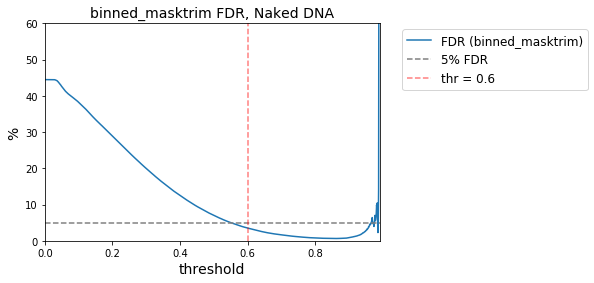

In [151]:
plt.plot(bin_edges_binned_masktrim[7][:-1],np.divide((1-cdf_binned_masktrim[8]),((1-cdf_binned_masktrim[7])+(1-cdf_binned_masktrim[8])))*100, label = 'FDR (binned_masktrim)' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.6, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.6')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('binned_masktrim FDR, Naked DNA', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


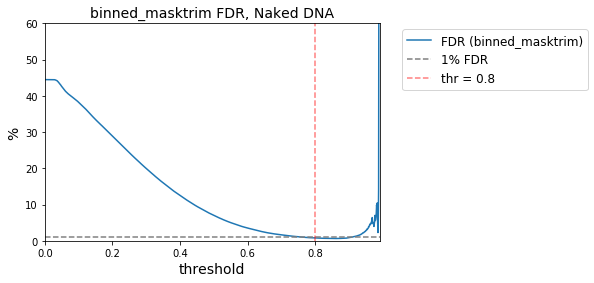

In [152]:
plt.plot(bin_edges_binned_masktrim[7][:-1],np.divide((1-cdf_binned_masktrim[8]),((1-cdf_binned_masktrim[7])+(1-cdf_binned_masktrim[8])))*100, label = 'FDR (binned_masktrim)' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(1, color='grey', linestyle='--', label = '1% FDR')
plt.axvline(0.8, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.8')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('binned_masktrim FDR, Naked DNA', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


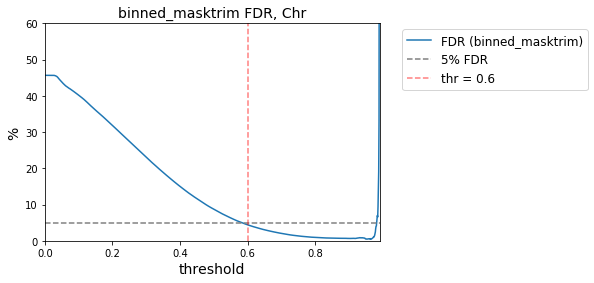

In [153]:
plt.plot(bin_edges_binned_masktrim[3][:-1],np.divide((1-cdf_binned_masktrim[4]),((1-cdf_binned_masktrim[3])+(1-cdf_binned_masktrim[4])))*100, label = 'FDR (binned_masktrim)' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.6, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.6')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('binned_masktrim FDR, Chr', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Calling nucleosomes on binned reads with > 0.2 methylation (thr 0.6)

In [161]:
#Identifying reads that have at least 20 % bins with average methylation probability > 0.6

In [191]:
nuc_called_reads_masktrim = {}
numbins = np.shape(AT_prob_arr_bin_mA_masktrim[1])[1]
print('ROI ', lefttrim, righttrim)
print('number of bins total = ', numbins)
print('total region considered', str(numbins * stepsize) + ' bp')
sensitivity = pd.DataFrame(index = [(Barcode_name[i]) for i in barcodes_list])
for numbins_threshold in [75]:
    thresh = numbins_threshold/numbins
    for i in barcodes_list:
        nuc_called_reads_masktrim[i] = np.sum(AT_prob_arr_bin_mA_masktrim[i] > 0.6, axis = 1)/numbins > thresh
        #same as :
        #nuc_called_reads_masktrim[i] = np.mean(AT_prob_arr_bin_mA_masktrim[i] > 0.8, axis = 1) > thresh
    #print('minimum number of methylated bins = ', numbins_threshold)
    #print(str(numbins_threshold*stepsize) + ' bp methylated out of ' + str(numbins*stepsize) + 'bp region')
    sensitivity[str(numbins_threshold)] = [(np.round(np.sum(nuc_called_reads_masktrim[i])/5000*100,1))  for i in barcodes_list]
sensitivity


ROI  160 610
number of bins total =  450
total region considered 450 bp


,75
"CA Chr, CA-DiMeLo",76.4
"CA Chr, IgG-DiMeLo",6.1
"CA Chr, free pA-Hia5",98.4
"CA Chr, Untreated",4.4
"Naked, CA-DiMeLo",16.8
"Naked, IgG-DiMeLo",14.6
"Naked, free pA-Hia5",98.5
"Naked, Untreated",4.9


In [97]:
lefttrim_only = 160
righttrim_only = 610

In [98]:
AT_prob_arr_bin_mA_trimonly = {}
for i in barcodes_list:
    AT_prob_arr_bin_mA_trimonly[i] = AT_prob_arr_bin_mA[i][:,int(lefttrim_only/stepsize):int(righttrim_only/stepsize)]

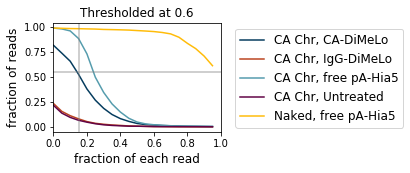

In [115]:
colorpal2 = ['#053C5E','#BB4420','#559CAD','#610345','#2D1E2F','#2D1E2F','#FFBC0A']
for frac in [0.6]:
    frac_methylated_read = {}
    fig = plt.figure(figsize = (3,2))

    for i in [1,2,3,4,7]:
        frac_methylated_read[i] = []
        for binfrac in np.arange(0,1,0.05):
            frac_methylated_read[i].append(np.sum((np.mean(AT_prob_arr_bin_mA_trimonly[i]>frac, axis = 1)>binfrac))/5000)

        
        plt.plot(np.arange(0,1,0.05), frac_methylated_read[i], label = Barcode_name[i], color = colorpal2[i-1])
    plt.axvline(0.15,0,1, color = 'grey', alpha = 0.5)
    #plt.axhline(0.05,0,1, color = 'grey', alpha = 0.5)
    plt.axhline(0.55,0,1, color = 'grey', alpha = 0.5)
    legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Thresholded at ' + str(frac), fontsize=12)
    plt.xlabel('fraction of each read', fontsize = 12)
    plt.ylabel('fraction of reads', fontsize = 12)
    plt.xlim(0,1)
    #plt.xlabel('threshold', fontsize=14)
    legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.savefig(outfolder+'fracVfrac_binned_threshold_wNkd'+str(int(frac*100))+'_hvlines.png', dpi = 300, bbox_inches='tight')
    export_legend(legend, str(outfolder + 'fracVfrac_binned_threshold_legend_wNkd.png'))

    plt.show()

In [95]:
sensitivity = pd.DataFrame(index = [(Barcode_name[i]) for i in barcodes_list])
sensitivity_norm = pd.DataFrame(index = [(Barcode_name[i]) for i in barcodes_list])

for halfwidth in [100,125,150,200,250,300,350]:

    lefttrim_only = 356 - halfwidth
    righttrim_only = 356 + halfwidth

    AT_prob_arr_bin_mA_trimonly = {}
    for i in barcodes_list:
        AT_prob_arr_bin_mA_trimonly[i] = AT_prob_arr_bin_mA[i][:,int(lefttrim_only/stepsize):int(righttrim_only/stepsize)]

    nuc_called_reads_trimonly = {}
    numbins = np.shape(AT_prob_arr_bin_mA_trimonly[1])[1]
    '''print('ROI ', lefttrim_only, righttrim_only)
    print('number of bins total = ', numbins)
    print('total region considered', str(numbins * stepsize) + ' bp')
    '''
    for numbins_threshold in [1]:
        thresh = numbins_threshold/numbins
        for i in barcodes_list:
            nuc_called_reads_trimonly[i] = (np.mean(AT_prob_arr_bin_mA_trimonly[i] > 0.6, axis = 1) > thresh)*(np.mean(AT_prob_arr_bin_mA_trimonly[i] > 0.8, axis = 1) < 1)
        #print('minimum number of methylated bins = ', numbins_threshold)
        #print(str(numbins_threshold*stepsize) + ' bp methylated out of ' + str(numbins*stepsize) + 'bp region')
        sensitivity[str(halfwidth)] = [(np.round(np.sum(nuc_called_reads_trimonly[i])/5000*100,2))  for i in barcodes_list]
        sensitivity_norm[str(halfwidth)] = [(np.round(np.sum(nuc_called_reads_trimonly[i])/np.sum(nuc_called_reads_trimonly[7])*100,2))  for i in barcodes_list]


In [163]:
for bp in ['A','T','AT']:
    AT_prob_arr_bar_filt50[bp] = np.zeros((5000,730))
    #AT_prob_arr_bar_filt50[bp][:] = np.NaN
for baseind in A_pos:
    AT_prob_arr_bar_filt50['A'][:,baseind] = 256
for baseind in T_pos:
    AT_prob_arr_bar_filt50['T'][:,baseind] = 256
for baseind in A_pos:
    AT_prob_arr_bar_filt50['AT'][:,baseind] = 256
for baseind in T_pos:
    AT_prob_arr_bar_filt50['AT'][:,baseind] = 256

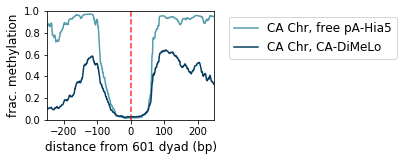

In [151]:
fig = plt.figure(figsize=(3,2))

a = {3:'#559CAD', 1:'#053C5E'}
for i in [3,1]:
    plt.plot(np.arange(0,np.shape(AT_prob_arr_bin_mA_trimonly[i])[1])-356+25,np.mean(AT_prob_arr_bin_mA_trimonly[i] > 0.6, axis = 0), color = a[i], label = Barcode_name[i])
    #legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.title(str(binsize) + 'bp bin positions thresholded at ' + '0.6')
    plt.xlabel('distance from 601 dyad (bp)', fontsize=12)
    plt.ylabel('frac. methylation', fontsize = 12)
    plt.ylim(0,1)
    plt.xlim(-250,250)
    plt.axvline(0,0,1, linestyle = '--',color = 'red', alpha = 0.5)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(outfolder+'601_centered_325_08.png', dpi = 300, bbox_inches='tight')
export_legend(legend, str(outfolder + '601_centered_legend.png'))

plt.show()

In [164]:
for i in ['A', 'T', 'AT']:
    AT_prob_arr_bin_mA[i] = np.zeros((5000,int(templatelength/stepsize)))
    indx = 0
    for a in range(stepsize,templatelength, stepsize):
        AT_prob_arr_bin_mA[i][:,indx] = np.nan_to_num(np.nanmean(AT_prob_arr_bar_filt50[i][:,a-int(binsize/2):a+int(binsize/2)], axis=1))/256
        indx += 1

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [165]:
for i in ['A', 'T', 'AT']:
    AT_prob_arr_bin_mA_trimonly[i] = AT_prob_arr_bin_mA[i][:,int(lefttrim_only/stepsize):int(righttrim_only/stepsize)]

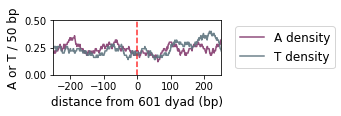

In [203]:
fig = plt.figure(figsize=(3,1))

col = {'A':'#610345', 'T':'#5E747F'}
for i in ['A','T']:
    if i == 'A':
        alp = 0.7
    else:
        alp = 0.9
    plt.plot(np.arange(0,np.shape(AT_prob_arr_bin_mA_trimonly[i])[1])-356+25,np.mean(AT_prob_arr_bin_mA_trimonly[i], axis = 0), color = col[i], label = Barcode_name[i], alpha = alp)
    #legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.title(str(binsize) + 'bp bin positions thresholded at ' + '0.6')
    plt.xlabel('distance from 601 dyad (bp)', fontsize=12)
    plt.ylabel('A or T / 50 bp', fontsize = 12)
    plt.ylim(0,0.5)
    plt.xlim(-250,250)
    plt.axvline(0,0,1, linestyle = '--',color = 'red', alpha = 0.5)
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(outfolder+'601_centered_325_ATper50bp.png', dpi = 300, bbox_inches='tight')
export_legend(legend, str(outfolder + '601_centered_250_ATper50bp_legend.png'))

plt.show()

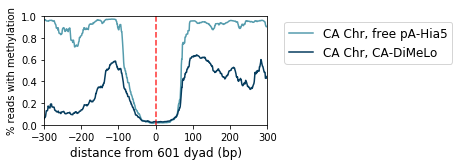

<function matplotlib.pyplot.show>

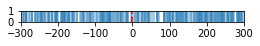

In [170]:
fig = plt.figure(figsize=(4,2))

a = {3:'#559CAD', 1:'#053C5E'}
for i in [3,1]:
    plt.plot(np.arange(0,np.shape(AT_prob_arr_bin_mA[i])[1])-(356),np.mean(AT_prob_arr_bin_mA[i] > 0.6, axis = 0), color = a[i], label = Barcode_name[i])
    legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.title(str(binsize) + 'bp bin positions thresholded at ' + '0.6')
    plt.xlabel('distance from 601 dyad (bp)', fontsize=12)
    plt.ylabel('% reads with methylation')
    plt.ylim(0,1)
    plt.xlim(-300,300)
    plt.axvline(0,0,1, linestyle = '--',color = 'red', alpha = 0.5)
plt.show()

plt.figure(figsize = (4,0.2))
for bp in A_pos:
    plt.axvline(bp-356,alpha =0.5)
    plt.ylim(0,1)
for bp in T_pos:
    plt.axvline(bp-356,alpha = 0.5)
    plt.ylim(0,1)
    plt.xlim(-300,300)
plt.axvline(0, 0,1, color='red', linestyle='--')

plt.show


In [ ]:
## Trying effect of binning size on these aggregate plotes:

### Clustering reads by bins with methylation > thr

In [183]:
d_rows={}
row_linkage_mod = {}

In [184]:
for i in [1,3,2]:

    d_rows[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA[i]>0.8),metric='jaccard')

    row_linkage_mod[i] = hierarchy.linkage(ssd.squareform(d_rows[i]), method='average',optimal_ordering=True)

In [185]:
m6ABlue = sns.light_palette("#053C5E", 1000)
m6ABlue[0] = (1,1,1)

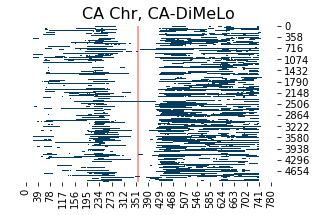

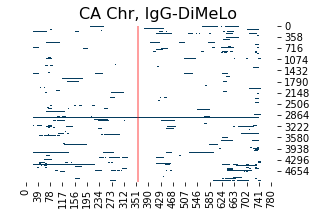

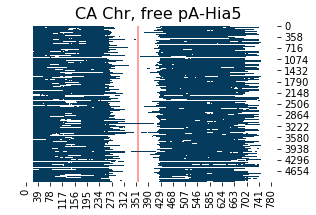

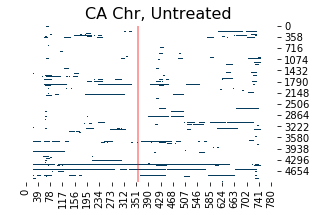

In [211]:
for i in [1,2,3,4]:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA[i]>0.6), pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=False, col_cluster=False, row_linkage=None, col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    plt.axvline(356,0,1, color = 'red', alpha = 0.5)
    #plt.axvline(606,0,1, color = 'g', alpha = 0.5)
    #plt.axvline(106,0,1, color = 'g', alpha = 0.5)
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'noncluster_mod06_' + str(i) + '.png', dpi=300)
    clstmap.savefig(outfolder + 'noncluster_mod06_' + str(i) + '.pdf', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

In [187]:
d_rows2={}
row_linkage_mod2 = {}

In [188]:
for i in [1,3]:

    d_rows2[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA[i]>0.6),metric='jaccard')

    row_linkage_mod2[i] = hierarchy.linkage(ssd.squareform(d_rows[i]), method='average',optimal_ordering=True)

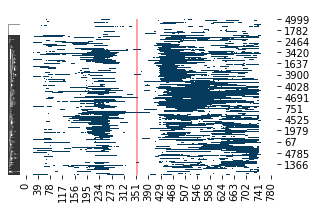

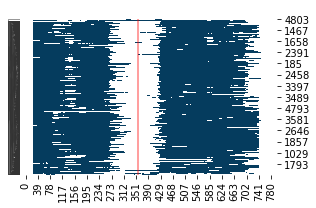

In [213]:
for i in [1,3]:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA[i]>0.6), pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod2[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    plt.axvline(356,0,1, color = 'red', alpha = 0.5)
    #plt.axvline(606,0,1, color = 'g', alpha = 0.5)
    #plt.axvline(106,0,1, color = 'g', alpha = 0.5)
    #clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    #clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.png', dpi=300)
    #clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.pdf', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()